In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import hfmfit as hf
import numba as nb

from scipy.sparse import coo_matrix
from scipy.linalg import block_diag, pinvh

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 300
signal_to_noise = 4


nsamples = 20
L = 4

ranks = np.array([4, 3, 2, 1])
rank = ranks.sum()

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = hf.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=300.0
level=1, num_groups=3, mean_size=100.0
level=2, num_groups=8, mean_size=37.5
level=3, num_groups=300, mean_size=1.0


In [5]:
true_mlr, true_sparse_F, true_D_noise = hf.generate_mlr_model(n, hpart, ranks, signal_to_noise)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=8.837876183246516, noise_var=2.2576120524425716
SNR=3.9147010106030304, signal_to_noise=4


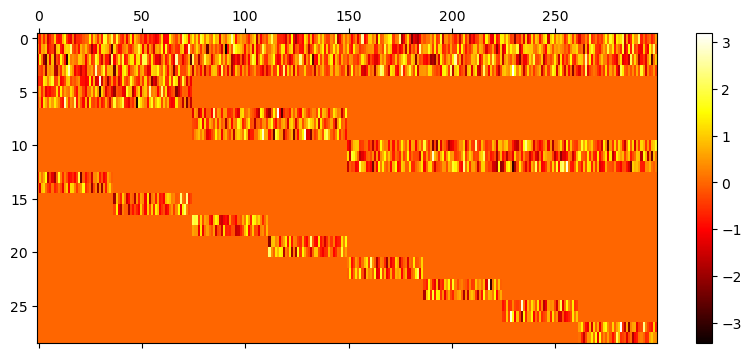

(300, 29)


In [6]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [7]:
type(true_sparse_F)

numpy.ndarray

In [8]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [9]:
row_selectors, si_groups, F_hpart, groups_all = hf.row_col_selections(hpart, return_groups=True)

num_levels=4, num_sparsities=8
(8, 3) [0 2 7]


In [10]:
def convert_compressed_to_sparse(B:np.ndarray, hp_entry:mf.EntryHpartDict, ranks:np.ndarray, mtype='csc'):
    # tilde_F0 = convert_compressed_to_sparse(F0, F_hpart, ranks[:-1])
    data, i_idx, j_idx = [], [], []
    col_count = 0
    num_levels = len(hp_entry['lk'])
    for level in range(num_levels):
        # B_level = B[:,ranks[:level].sum():ranks[:level+1].sum()]
        num_blocks = len(hp_entry['lk'][level])-1
        for block in range(num_blocks):
            r1, r2 = hp_entry['lk'][level][block], hp_entry['lk'][level][block+1]
            data += [B[:,ranks[:level].sum():ranks[:level+1].sum()][r1:r2].flatten(order='C')]
            i_idx += [np.tile(np.arange(r1, r2), [ranks[level],1]).flatten(order='F')]
            j_idx += [np.tile(np.arange(col_count, col_count+ranks[level]), [r2-r1])]
            col_count += ranks[level]
    data = np.concatenate(data, axis=0)
    i_idx = np.concatenate(i_idx, axis=0)
    j_idx = np.concatenate(j_idx, axis=0)

    s = sum([(len(hp_entry['lk'][level])-1)*ranks[level] for level in range(num_levels)])
    tilde_B = coo_matrix((data, (i_idx, j_idx)), shape=(B.shape[0], s))
    if mtype == 'csc':
        tilde_B = tilde_B.tocsc()
    elif mtype == 'csr':
        tilde_B = tilde_B.tocsr()
    return tilde_B


In [11]:
def block_diag_AB(lk:np.array, A:np.ndarray, B:np.ndarray):
    # return blockdiagonal(A) @ blockdiagonal(B)
    res = []
    num_blocks = lk.size - 1
    for block in range(num_blocks):
        r1, r2 = lk[block], lk[block+1]
        res += [ A[r1:r2] @ B[:, r1:r2] ]
    return block_diag(*res)


def block_diag_lk(lk:np.array, A:np.ndarray):
    # return blockdiagonal(A)
    res = []
    num_blocks = lk.size - 1 
    for block in range(num_blocks):
        r1, r2 = lk[block], lk[block+1]
        res += [ A[r1:r2]]
    return block_diag(*res)


def mult_blockdiag_refined_AtB(A, lk_A, B, lk_B):
    # multiply blockdiagonal matrix by blockdiagonal matrix
    # blockdiagonal(At) @ blockdiagonal(B)
    # At has column sparity that is a refinement of B row sparsity
    # A, B given in compressed format
    assert lk_A.size >= lk_B.size and lk_B[-1] == B.shape[0] and lk_A[-1] in A.shape
    num_blocks_A = lk_A.size - 1
    res = np.zeros((A.shape[1] * (lk_A.size - 1), B.shape[1]))
    # decide whether make A block diagonal by splitting rows or columns
    for block_A in range(num_blocks_A):
        r1, r2 = lk_A[block_A], lk_A[block_A+1]
        res[block_A * A.shape[1] : (block_A+1) * A.shape[1]] = A[r1:r2].T @ B[r1:r2]
    return res


def mult_blockdiag_refined_AB(A, lk_A, B, lk_B):
    # multiply blockdiagonal matrix by blockdiagonal matrix
    # blockdiagonal(A) @ blockdiagonal(B)
    # A has column sparity that is a refinement of B row sparsity
    # A, B given in compressed format
    assert lk_A.size >= lk_B.size and lk_B[-1] == B.shape[0] and lk_A[-1] in A.shape
    num_blocks_A = lk_A.size - 1
    res = np.zeros((A.shape[0], B.shape[1]))
    # decide whether make A block diagonal by splitting rows or columns
    for block_A in range(num_blocks_A):
        r1, r2 = lk_A[block_A], lk_A[block_A+1]
        res[r1 : r2] = A[r1:r2] @ B[block_A * A.shape[1] : (block_A+1) * A.shape[1]]
    return res


@nb.njit(parallel=True)
def jit_mult_blockdiag_refined_AtB(A, lk_A, B, lk_B):
    # multiply blockdiagonal matrix by blockdiagonal matrix
    # blockdiagonal(At) @ blockdiagonal(B)
    # At has column sparity that is a refinement of B row sparsity
    # A, B given in compressed format
    num_blocks_A = lk_A.size - 1
    res = np.zeros((A.shape[1] * (lk_A.size - 1), B.shape[1]))
    # decide whether make A block diagonal by splitting rows or columns
    for block_A in nb.prange(num_blocks_A):
        r1, r2 = lk_A[block_A], lk_A[block_A+1]
        res[block_A * A.shape[1] : (block_A+1) * A.shape[1]] = A[r1:r2].T @ B[r1:r2]
    return res

In [12]:
for level_A in range(len(F_hpart["lk"])): 
    for level_B in range(level_A+1):
        lk_A = F_hpart['lk'][level_A]
        lk_B = F_hpart['lk'][level_B]
        A = true_compressed_F[:,ranks[:level_A].sum():ranks[:level_A+1].sum()]
        B = true_compressed_F[:,ranks[:level_B].sum():ranks[:level_B+1].sum()]
        
        AtB = block_diag_lk(lk_A, A).T @  block_diag_lk(lk_B, B)
        res = mult_blockdiag_refined_AtB(A, lk_A, B, lk_B)
        # res2 = jit_mult_blockdiag_refined_AtB(A, lk_A, B, lk_B)
        # indices of groups in A that refine groups in B
        indices_A2B = np.searchsorted(lk_A, lk_B, side='left') * ranks[level_A]
        assert np.allclose(AtB, block_diag_lk(indices_A2B, res)) 
        # assert np.allclose(AtB, block_diag_lk(indices_A2B, res2))

        AAt = hf.block_diag_FFt(level_A, F_hpart, A)
        assert np.allclose(AAt, block_diag_AB(lk_A, A, A.T)) and np.allclose(AAt, block_diag_lk(lk_A, A) @  block_diag_lk(lk_A, A).T)

print("PASSED")

PASSED


In [13]:
F_Lm1, D = true_compressed_F+0, true_D_noise+0
v = np.random.randn(n)

In [14]:
def compressed2sparse_recurrence(compressed_rec, lks, ranks):
    # convert compressed form of recurrence term to sparse
    res = []
    cumsum = 0
    for lk, rank in zip(lks, ranks):
        res += [block_diag_lk(lk, compressed_rec[:, cumsum : cumsum+rank ])]
        cumsum += rank 
    return np.concatenate(res, axis=1)

In [15]:
v_F_Lm1 = np.concatenate([v[:, np.newaxis], F_Lm1], axis=1)
prev_l_recurrence = (1/D[:, np.newaxis]) * v_F_Lm1
ranks_v = ranks + 0
ranks_v[0] += 1

sparse_v_F_lm1 = np.concatenate([v[:, np.newaxis], true_sparse_F], axis=1)
sparse_prev_l_recurrence = (1/D[:, np.newaxis]) * sparse_v_F_lm1
assert np.allclose(np.diag(1/D) @ true_compressed_F, prev_l_recurrence[:, 1:])
assert np.allclose(sparse_prev_l_recurrence, compressed2sparse_recurrence(prev_l_recurrence, F_hpart["lk"], ranks_v))

In [16]:
size_v_F_l = np.array([F_hpart["lk"][l].size-1 for l in range(L-1)]) * ranks_v[:-1]
pl_all = np.array([F_hpart["lk"][l].size-1 for l in range(L-1)])
for level in reversed(range(1, L-1)):
    print(f"{level=}")
    pl = F_hpart['lk'][level].size - 1
    rl = ranks[level]
    assert prev_l_recurrence.shape == (n, 1 + ranks[:level+1].sum())
    assert np.allclose(sparse_prev_l_recurrence, compressed2sparse_recurrence(prev_l_recurrence, F_hpart["lk"][:level+1], ranks_v[:level+1]))
    # M0 same sparsity as Fl
    M0 = prev_l_recurrence[:, -ranks_v[level]:]

    # M1 = M0.T @ rec_term, same sparsity as rec_term
    M1 = np.zeros((rl * pl, 1 + ranks[:level].sum()))
    for lp in range(level):
        M1[:, ranks_v[:lp].sum() : ranks_v[:lp+1].sum()] = mult_blockdiag_refined_AtB(M0, 
                                                                                      F_hpart['lk'][level], 
                                                                                      v_F_Lm1[:,ranks_v[:lp].sum():ranks_v[:lp+1].sum()], F_hpart['lk'][lp])
    # check M1 computation
    sparse_M0 = sparse_prev_l_recurrence[:, -size_v_F_l[-1]:]
    sparse_M1 = sparse_M0.T @ sparse_v_F_lm1[:, :size_v_F_l[:level].sum()]
    M1_lks = [np.linspace(0, pl*rl, num=plp+1, endpoint=True, dtype=int) for plp in pl_all[:level]]
    assert np.allclose(sparse_M1, compressed2sparse_recurrence(M1, M1_lks, ranks_v[:level]))
    # del sparse_M0, sparse_M1


    # M2 = (I + Fl^T M0)^{-1}, blockdiagonal with pl blocks of size (rl x rl)
    FlTM0 = mult_blockdiag_refined_AtB(v_F_Lm1[:,ranks_v[:level].sum():ranks_v[:level+1].sum()], 
                                       F_hpart['lk'][level], 
                                       M0, 
                                       F_hpart['lk'][level])
    # check Fl^TM0 computation
    sparse_FlTM0 = sparse_v_F_lm1[:, size_v_F_l[:level].sum():size_v_F_l[:level+1].sum()].T @ sparse_M0
    assert np.allclose(sparse_FlTM0, block_diag_lk(np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int), FlTM0))
    M2 = np.zeros((pl*rl, rl))
    for k in range(pl):
        np.fill_diagonal(FlTM0[k*rl : (k+1)*rl], FlTM0[k*rl : (k+1)*rl].diagonal() + 1)
        M2[k*rl : (k+1)*rl] = pinvh(FlTM0[k*rl : (k+1)*rl])
        # M2[k*rl : (k+1)*rl] = pinvh(np.eye(rl) + FlTM0[k*rl : (k+1)*rl])
    # check M2 computation, symmetric PD matrix
    sparse_M2 = np.linalg.inv(np.eye(rl*pl) + sparse_FlTM0)
    assert np.allclose(sparse_M2, block_diag_lk(np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int), M2))


    # M3 = M2 @ M1, same sparsity as M1
    M3 = np.zeros((rl * pl, 1 + ranks[:level].sum()))
    for lp in range(level):
        M3[:, ranks_v[:lp].sum():ranks_v[:lp+1].sum()] = mult_blockdiag_refined_AtB(M2, 
                                                                                    np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int), 
                                                                                    M1[:,ranks_v[:lp].sum():ranks_v[:lp+1].sum()], 
                                                                                    M1_lks[lp])
    # check M3 computation
    sparse_M3 = sparse_M2 @ sparse_M1
    assert np.allclose(sparse_M3, compressed2sparse_recurrence(M3, M1_lks, ranks_v[:level]))


    # M4 = M0 @ M3, same sparsity as current rec_term
    M4 = np.zeros((n, 1 + ranks[:level].sum()))
    for lp in range(level):
        M4[:, ranks_v[:lp].sum() : ranks_v[:lp+1].sum()] = mult_blockdiag_refined_AB(M0, 
                                                                                      F_hpart["lk"][level], 
                                                                                      M3[:,ranks_v[:lp].sum():ranks_v[:lp+1].sum()], 
                                                                                      M1_lks[lp])
    # check M4 computation
    sparse_M4 = sparse_M0 @ sparse_M3
    assert np.allclose(sparse_M4, compressed2sparse_recurrence(M4, F_hpart["lk"][:level], ranks_v[:level]))


    # M5 
    prev_l_recurrence = prev_l_recurrence[:, :ranks_v[:level].sum()] - M4
    # check M5 computation
    sparse_prev_l_recurrence = sparse_prev_l_recurrence[:, :size_v_F_l[:-1].sum()] - sparse_M4
    assert np.allclose(sparse_prev_l_recurrence, compressed2sparse_recurrence(prev_l_recurrence, F_hpart["lk"][:level], ranks_v[:level]))
    print("PASSED")

level=2


AssertionError: 

In [ ]:
np.linalg.norm(sparse_M3 - compressed2sparse_recurrence(M3, M1_lks, ranks_v[:level]), ord='fro')

4.19551151001304

In [ ]:
M1_lks

[array([0, 5]), array([ 0,  3,  6,  9, 12])]

In [ ]:
sparse_M1.shape, compressed2sparse_recurrence(M1, F_hpart["lk"][:level], ranks_v[:level]).shape

((16, 17), (16, 17))

In [ ]:
prev_l_recurrence.shape

(300, 10)

In [ ]:
np.arange(20)[-5:]

array([15, 16, 17, 18, 19])

In [ ]:
F_l_sizes = np.array([F_hpart["lk"][l].size-1 for l in range(L-1)]) * ranks[:-1]
F_l_sizes.sum()

32

In [ ]:
sparse_prev_l_recurrence.shape, true_sparse_F.shape

((300, 33), (300, 32))

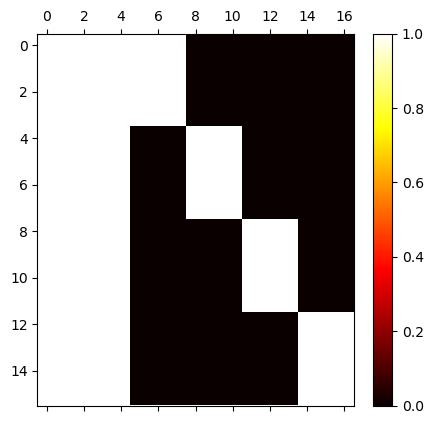

In [ ]:
# plt.figure(figsize=(10, 4)) 
# plt.matshow(M1, aspect='auto', fignum=1, cmap='hot') 
# plt.matshow(sparse_M3.T!=0, aspect='auto', fignum=1, cmap='hot') 
plt.matshow((sparse_M3 - compressed2sparse_recurrence(M3, M1_lks, ranks_v[:level]))!=0, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()